In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import copy

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths
from utils import prf_utils

import pandas as pd
import statsmodels.stats.anova
import scipy.stats
import statsmodels.stats.multitest
from utils import stats_utils


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False, return_filename=False) \
       for ss in subjects]

In [3]:
# pull out the pRF params

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = np.round(sigma * screen_eccen_deg, 2)
angle_fwrf = np.round(angle_fwrf,2)
eccen_fwrf = np.round(eccen_fwrf,2)

x_fwrf, y_fwrf = x*screen_eccen_deg, y*screen_eccen_deg

In [4]:
# define linearly spaced bins for each parameters, use for histograms
size_bins = np.linspace(0.10, 8.5, 10)
eccen_bins = np.linspace(0, 7.1, 10)
x_bins = np.linspace(-7.1, 7.1, 10); 
y_bins = np.linspace(-7.1, 7.1, 10)

In [5]:
# non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [6]:
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff


#### Creating histograms, grouping voxels across multiple ROIs (early/place/face)

In [7]:
roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

hist_values = [np.zeros((n_roi_groups, len(bins)-1)) for bins in [size_bins, eccen_bins, y_bins, x_bins]]
n_par_types = 4;

bin_centers_eachpar = [[] for par in range(n_par_types)]

median_eachpar = np.zeros((n_roi_groups, n_par_types))
mean_eachpar = np.zeros((n_roi_groups, n_par_types))

for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    # bi = -1
    for bi, [bins, par_vals] in enumerate(zip([size_bins, eccen_bins, y_bins, x_bins], \
                                              [size_fwrf, eccen_fwrf, y_fwrf, x_fwrf])):
        # bi+=1
        counts, bin_edges = np.histogram(par_vals[inds], bins=bins)
        assert(np.sum(counts)==np.sum(inds))
               
        # convert to proportion
        hist_values[bi][rr,:] = counts/np.sum(counts)
        
        bin_width = (bin_edges[1]-bin_edges[0])
        bin_centers = bins[0:-1]+bin_width/2
        
        bin_centers_eachpar[bi] = bin_centers
        
        median_eachpar[rr,bi] = np.median(par_vals[inds])
        mean_eachpar[rr,bi] = np.mean(par_vals[inds])
        

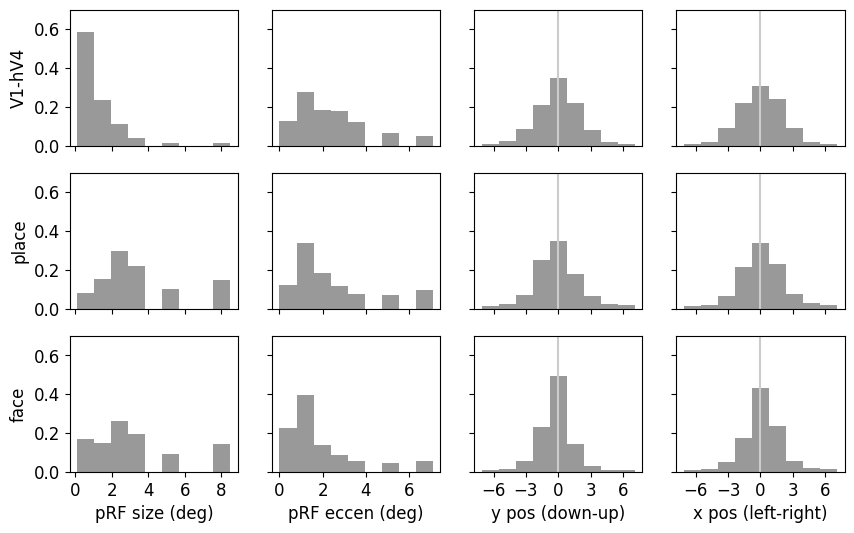

In [8]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = np.tile(np.array([[0.6, 0.6, 0.6,1]]), [n_roi_groups,1])

ylims = [0, 0.70]
yticks = [0, 0.2, 0.4, 0.6]

xticks = [[0,2,4,6,8], [0,2,4,6], [-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]]
xlims = [[0,8.5],[0,7.1],[-7.1,7.1],[-7.1,7.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

npx = n_roi_groups
# npx = n_roi_groups+1

plt.figure(figsize=(10,6));

pi=0;

for rr in range(n_roi_groups):

    for par in range(n_par_types):

        bar_centers = bin_centers_eachpar[par]

        bar_heights = hist_values[par][rr,:]
        name = roi_group_names[rr]

        pi+=1
        plt.subplot(npx,4,pi)

        bin_width = bar_centers[1] - bar_centers[0]
        plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

        if rr==(npx-1):
            plt.xlabel(par_names[par])
            plt.xticks(xticks[par])
        else:
            plt.xticks(xticks[par], labels=[])

        plt.ylim(ylims)
            
        if par==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])

        if par>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
            
        # plt.axvline(median_eachpar[rr,par], color=[0, 0.7, 0.8, 1])
        # plt.axvline(mean_eachpar[rr,par], color=[0, 0.7, 0.8, 1])
            
fn2save = os.path.join(default_paths.fig_path, 'prf_params_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

#### Make Supplementary Figure 6

Plot each individual ROI

In [9]:
hist_values = [np.zeros((n_rois, len(bins)-1)) for bins in [size_bins, eccen_bins, y_bins, x_bins]]
n_par_types = 4;

bin_centers_eachpar = [[] for par in range(n_par_types)]

for rr in range(n_rois):
    
    inds = roi_def.get_indices(rr) & abv_thresh

    for bi, [bins, par_vals] in enumerate(zip([size_bins, eccen_bins, y_bins, x_bins], \
                                              [size_fwrf, eccen_fwrf, y_fwrf, x_fwrf])):
             
        counts, bin_edges = np.histogram(par_vals[inds], bins=bins)
        
        hist_values[bi][rr,:] = counts/np.sum(counts)
        
        bin_width = (bin_edges[1]-bin_edges[0])
        bin_centers = bins[0:-1]+bin_width/2
        
        bin_centers_eachpar[bi] = bin_centers
        

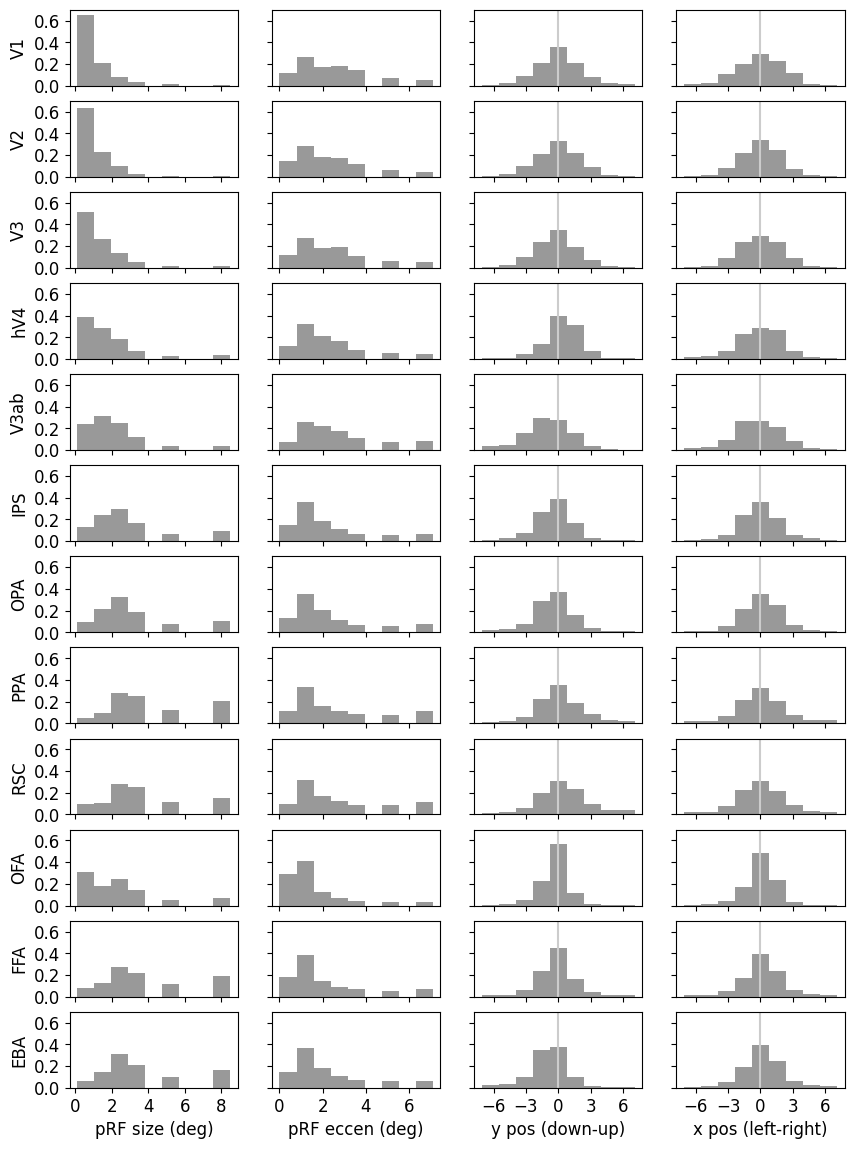

In [10]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = np.tile(np.array([[0.6, 0.6, 0.6,1]]), [n_rois,1])

ylims = [0, 0.70]
yticks = [0, 0.2, 0.4, 0.6]

ylims_diff = [-0.4, 0.4]
yticks_diff = [-0.2, 0, 0.2]

xticks = [[0,2,4,6,8], [0,2,4,6], [-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]]
xlims = [[0,8.5],[0,7.1],[-7.1,7.1],[-7.1,7.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

npx = n_rois

plt.figure(figsize=(10,14));

pi=0;

for rr in range(n_rois):

    for par in range(n_par_types):

        bar_centers = bin_centers_eachpar[par]

        bar_heights = hist_values[par][rr,:]
        name = roi_names[rr]

        pi+=1
        plt.subplot(npx,4,pi)

        bin_width = bar_centers[1] - bar_centers[0]
        plt.bar(bar_centers, bar_heights, width=bin_width,facecolor=[0.6,0.6,0.6,1])

        # plt.xlim(xlims[par])
        if rr==(npx-1):
            plt.xlabel(par_names[par])
            plt.xticks(xticks[par])
        else:
            plt.xticks(xticks[par], labels=[])

        plt.ylim(ylims)
            
        if par==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])

        if par>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8, 1])
            
            
fn2save = os.path.join(default_paths.fig_path, 'prf_params_allrois.pdf')
plt.savefig(fn2save, format='pdf')

#### Plot eccentricity versus size, binned

V1-hV4: rho=0.53, p=0.00000
place: rho=0.43, p=0.00000
face: rho=0.44, p=0.00000


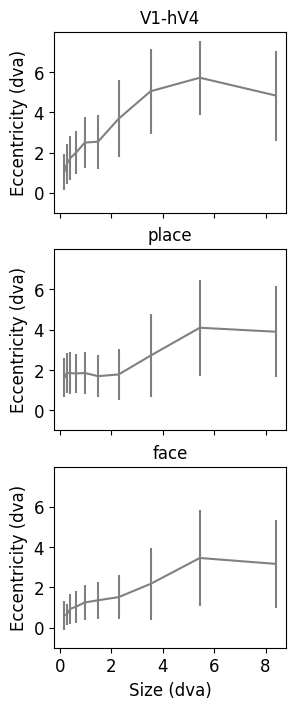

In [11]:
from utils import numpy_utils
import scipy

plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

plt.figure(figsize=(3,8))
# plt.figure(figsize=(8,2))

for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = size_fwrf[inds]
    yvals = eccen_fwrf[inds]
    rho, p = scipy.stats.pearsonr(xvals, yvals)
    print('%s: rho=%.2f, p=%.5f'%(roi_group_names[rr], rho, p))
          
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Size (dva)')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
        
    plt.ylabel('Eccentricity (dva)')
        
    plt.ylim([-1,8])
    plt.yticks([0,2,4,6])
    # plt.axis('square')
    
fn2save = os.path.join(default_paths.fig_path, 'eccen_vs_size_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

#### Load the S.F. selectivity values

In [12]:
fitting_type = 'gabor_solo_ridge_12ori_8sf'
out_gabor = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# Get info about the Gabor feature space
from feature_extraction import gabor_feature_extractor
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)
sf_unique

# Organize the feature sensitivity matrices
# feature sensitivity = corr coef between model resp and feature channel activation
feature_corr = np.concatenate([out_gabor[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Plot spatial frequency selectivity of voxels versus pRF size

V1-hV4: rho=-0.31, p=0.00000
place: rho=-0.10, p=0.00000
face: rho=-0.03, p=0.00300


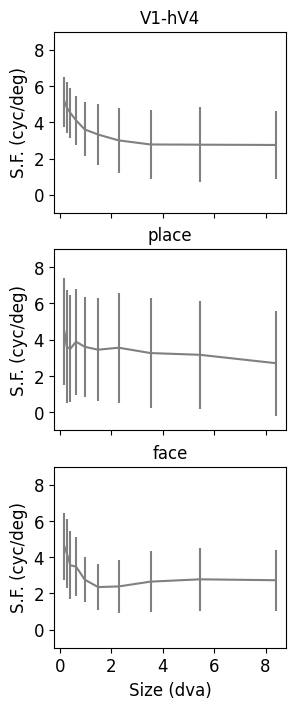

In [13]:
from utils import numpy_utils
plt.rcParams['pdf.fonttype']=42

roi_groups = [[0,1,2,3],[6,7,8],[9,10]]
roi_group_names = ['V1-hV4','place','face']
n_roi_groups = len(roi_groups)

# plt.figure(figsize=(8,2))
plt.figure(figsize=(3,8))
for rr in range(n_roi_groups):
    
    inds = np.any(np.array([roi_def.get_indices(ri) \
                                 for ri in roi_groups[rr]]), axis=0) \
                                    & abv_thresh
 
    xvals = size_fwrf[inds]
    yvals = preferred_sf_corr[inds]
    rho, p = scipy.stats.pearsonr(xvals, yvals)
    print('%s: rho=%.2f, p=%.5f'%(roi_group_names[rr], rho, p))
    
    
    plt.subplot(3,1,rr+1)
    # plt.plot(xvals, yvals, '.',color=[0.8, 0.8, 0.8])
    
    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(xvals, yvals, n_bins=10,\
                                  return_std=True, use_unique=True, linear_bins=False)
    plt.errorbar(xbinned, ybinned, ystd, color=[0.5, 0.5, 0.5, 1])
    plt.title(roi_group_names[rr])
    
    if rr==2:
        plt.xlabel('Size (dva)')
        plt.xticks([0,2,4,6,8])
    else:
        plt.xticks([0,2,4,6,8],[])
    plt.ylabel('S.F. (cyc/deg)')
        
    plt.ylim([-1,9])
      
    plt.yticks([0,2,4,6,8])
    
fn2save = os.path.join(default_paths.fig_path, 'sf_vs_size_bigroigroups.pdf')
plt.savefig(fn2save, format='pdf')

#### Now looking at visual field coverage
run this cell uncommented to compute pRF coverage maps

In [14]:
from analyze_fits import analyze_prfs
fitting_type = 'alexnet_all_conv_pca'
subjects = np.arange(1,9)
# analyze_prfs.compute_prf_coverage(subjects, fitting_type=fitting_type,image_size=100)

#### load the prf coverage maps, computed in analyze_prfs.py

In [15]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

fn = os.path.join(default_paths.save_fits_path, 'prf_coverage', \
                  'All_pRFs_%s_100pix.npy'%fitting_type)

prf_coverage = np.load(fn, allow_pickle=True).item()
image_size = prf_coverage['all_mean_prfs'].shape[0]

#### Plot visual field coverage, averaging all subjects

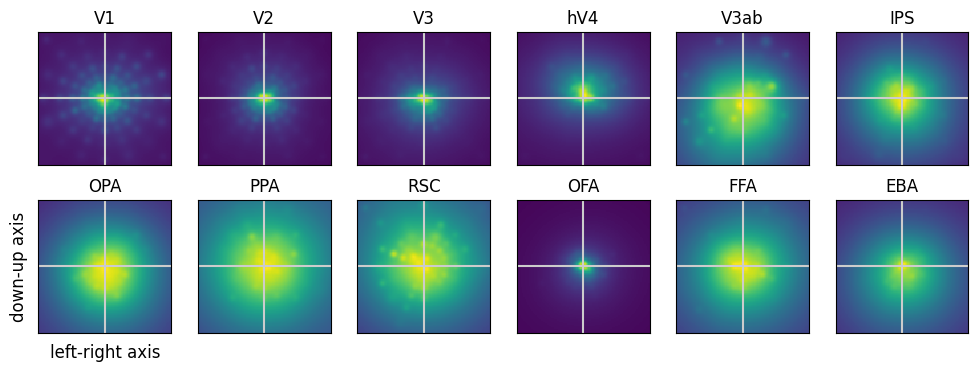

In [16]:
all_comb_prfs = copy.deepcopy(prf_coverage['all_mean_prfs'])
mean_allsubs = np.mean(all_comb_prfs[:,:,:,:], axis=3)

plt.figure(figsize=(12,4));
plt.rcParams['pdf.fonttype']=42

for rr in range(n_rois):

    plt.subplot(2,6,rr+1)

    meanvals = mean_allsubs[:,:,rr]
    meanvals /= np.max(meanvals) # normalizing just for visualization here
    
    plt.pcolormesh(meanvals, vmin=0, vmax=1)

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axvline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.axhline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.xticks([])
    plt.yticks([])
    
    if rr==6:
        plt.xlabel('left-right axis')
        plt.ylabel('down-up axis')

    plt.title('%s'%roi_names[rr])
    
fn2save = os.path.join(default_paths.fig_path, 'prf_coverage_allrois.pdf')
plt.savefig(fn2save, format='pdf')

#### Now compare the pRF coverage across quadrants of visual field
3-way RM anova (ROI x horizontal x vertical)

This is Supplementary Table 6

In [17]:

all_comb_prfs = copy.deepcopy(prf_coverage['all_mean_prfs'])
# all_comb_prfs /= np.max(np.max(all_comb_prfs, axis=0), axis=0)

image_size = all_comb_prfs.shape[0]

# compute avg values in each vis field quadrant
center = int(all_comb_prfs.shape[0]/2)
mean_ul = np.mean(np.mean(all_comb_prfs[0:center,0:center,:,:], axis=0), axis=0)
mean_ll = np.mean(np.mean(all_comb_prfs[center:,0:center,:,:], axis=0), axis=0)
mean_ur = np.mean(np.mean(all_comb_prfs[0:center,center:,:,:], axis=0), axis=0)
mean_lr = np.mean(np.mean(all_comb_prfs[center:,center:,:,:], axis=0), axis=0)

mean_each_quad = np.concatenate([mean_ul[:,:,np.newaxis], \
                                 mean_ur[:,:,np.newaxis], \
                                 mean_ll[:,:,np.newaxis], \
                                 mean_lr[:,:,np.newaxis]], axis=2)
quad_names = ['upper left', 'upper right','lower left', 'lower right']

prf_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'vert': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'horiz': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

prf_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for rr in range(n_rois):
        inds = (prf_df['subject']==si) & (prf_df['roi']==rr)
        # print(np.sum(inds))
        prf_values[inds] = mean_each_quad[rr,si,:]
prf_df['prf_values'] = prf_values

model = statsmodels.stats.anova.AnovaRM(data=prf_df, \
                                        depvar='prf_values', \
                                        subject='subject', \
                                        within = ['vert','horiz','roi'], \
                                        # within = ['roi','vert','horiz'], \
                                       )
rm_result = model.fit()
print(rm_result)

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
vert            3.2937  1.0000  7.0000 0.1124
horiz           3.8876  1.0000  7.0000 0.0893
roi             4.6667 11.0000 77.0000 0.0000
vert:horiz      0.0654  1.0000  7.0000 0.8055
vert:roi       10.6794 11.0000 77.0000 0.0000
horiz:roi       0.8826 11.0000 77.0000 0.5607
vert:horiz:roi  0.7167 11.0000 77.0000 0.7191



In [18]:
anova_table = pd.DataFrame(rm_result.anova_table)
anova_table.iloc[:,0] = anova_table.iloc[:,0].round(3)
anova_table['Num DF'] = anova_table['Num DF'].astype(int)
anova_table['Den DF'] = anova_table['Den DF'].astype(int)
anova_table['Pr > F'].map('${:,.4f}'.format)
# anova_table['Pr > F'] = anova_table.iloc[:,3].round(4)
anova_table

anova_table.to_csv(os.path.join(default_paths.fig_path,'prf_anova.csv'))

### t-tests within ROIs for effect of vertical pos

In [19]:
tstats_vert = np.zeros((n_rois,),dtype=float)
pvals_vert = np.zeros((n_rois,),dtype=float)
pvals_nonpar_vert = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 345351
for rr in range(n_rois):
    
    upper_values = mean_each_quad[rr,:,0:2].ravel()
    lower_values = mean_each_quad[rr,:,2:4].ravel()
    
    stats = scipy.stats.ttest_rel(upper_values, lower_values)
    
    tstats_vert[rr] = stats.statistic
    pvals_vert[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(upper_values, lower_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_vert[rr] = p
    
    subj_diffs = np.mean(mean_each_quad[rr,:,0:2], axis=1) - np.mean(mean_each_quad[rr,:,2:4], axis=1)
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_vert
p_values = pvals_nonpar_vert
orig_shape = p_values.shape
mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
                                                                alpha=0.01)
mask_fdr = np.reshape(mask_fdr, orig_shape)
pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
vertical_df = pd.DataFrame({'t-stat for upper>lower': tstats_vert, \
                           'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, 'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
mask_fdr_vert = mask_fdr
vertical_df.round(3)



,t-stat for upper>lower,pvalue_fdr,sig_fdr,n_subs_indiv
V1,-0.033,0.980,False,5
V2,-0.554,0.661,False,4
V3,-4.534,0.002,True,7
hV4,6.581,0.002,True,8
V3ab,-4.654,0.002,True,7
IPS,-1.296,0.273,False,6
OPA,-5.122,0.002,True,7
PPA,0.602,0.661,False,6
RSC,2.432,0.048,False,5
OFA,-3.494,0.002,True,8


### t-tests for horizontal (no effects here)

In [20]:
tstats_horiz = np.zeros((n_rois,),dtype=float)
pvals_horiz = np.zeros((n_rois,),dtype=float)
pvals_nonpar_horiz = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 456956
for rr in range(n_rois):
    
    left_values = np.take(mean_each_quad[rr,:,:],[0,2],axis=1)
    right_values = np.take(mean_each_quad[rr,:,:],[1,3],axis=1)
    
    stats = scipy.stats.ttest_rel(left_values.ravel(), right_values.ravel())
    
    tstats_horiz[rr] = stats.statistic
    pvals_horiz[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(left_values.ravel(), right_values.ravel(), \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_horiz[rr] = p
    
    subj_diffs = np.mean(left_values, axis=1) - np.mean(right_values, axis=1)
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_horiz
p_values = pvals_nonpar_horiz
orig_shape = p_values.shape
mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), alpha=0.01)
mask_fdr = np.reshape(mask_fdr, orig_shape)
pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
horiz_df = pd.DataFrame({'t-stat for left>right': tstats_horiz, \
                           'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, 'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
mask_fdr_horiz = mask_fdr
horiz_df.round(3)



,t-stat for left>right,pvalue_fdr,sig_fdr,n_subs_indiv
V1,-1.816,0.258,False,6
V2,-1.656,0.258,False,6
V3,0.249,0.809,False,4
hV4,-1.632,0.258,False,6
V3ab,1.048,0.472,False,7
IPS,0.333,0.809,False,4
OPA,-1.735,0.258,False,7
PPA,-0.778,0.588,False,5
RSC,0.468,0.785,False,6
OFA,-2.257,0.258,False,6


### plot the quadrant values for each ROI

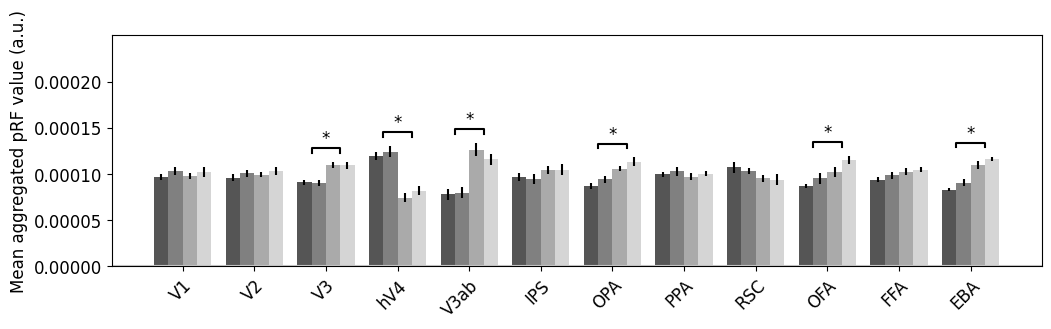

In [21]:
mean_vals = np.mean(mean_each_quad, axis=1)
sem_vals = np.std(mean_each_quad, axis=1)/np.sqrt(n_subjects)

quad_colors = cm.gray(np.linspace(0,1,7))[2:7,:]


plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                space=0.1, \
                xticklabels=roi_names, ylabel='Mean aggregated pRF value (a.u.)', \
                ylim=[0, 0.000250], title='',\
                legend_labels=quad_names, \
                colors = quad_colors, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,3),
                add_brackets = mask_fdr_vert, 
                bracket_text = ['*' if mask_fdr_vert[ri] else None for ri in range(n_rois) ])
plt.yticks(np.arange(0,0.00021, 0.00005))

fn2save = os.path.join(default_paths.fig_path,'Quadrant_avg_pRFs.pdf')
plt.savefig(fn2save)